In [1]:
from keras.applications import MobileNet
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

img_rows, img_cols = 224, 224

MobileNet = MobileNet(weights = 'imagenet',
                     include_top = False,
                     input_shape = (img_rows, img_cols, 3)
                     )

for layer in MobileNet.layers:
    layer.trainable = False

In [2]:
def addTopModelMobileNet(bottom_model, num_classes):
    
    top_model = bottom_model.output
    top_model = BatchNormalization()(top_model)
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(256,activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.001))(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = Dense(128, activation = 'relu')(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = Dense(64, activation = 'relu')(top_model)
    top_model = Dense(num_classes, activation = 'softmax')(top_model)
    
    return top_model
    

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.regularizers import l1, l2

num_classes = 3

FC_Head = addTopModelMobileNet(MobileNet, num_classes)

model = Model(inputs = MobileNet.input, outputs = FC_Head)

print(model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

In [4]:
from keras.preprocessing.image import ImageDataGenerator

data_dir = './data/train'
test_dir = './data/test'

In [5]:
datagen = ImageDataGenerator(
    validation_split = 0.2,
    rescale = 1./255,
    rotation_range = 45
    
    #width_shift_range = 0.3,
    #height_shift_range = 0.3,
    #horizontal_flip = False,
    #fill_mode = 'nearest'
)


batch_size = 16

train_generator = datagen.flow_from_directory(
    data_dir,
    subset ='training',
    target_size = (img_rows, img_cols),
    batch_size = batch_size,
    class_mode = 'categorical'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    subset = 'validation',
    target_size = (img_rows, img_cols),
    batch_size = batch_size,
    class_mode = 'categorical'
)


test_datagen = ImageDataGenerator( rescale = 1./255 )

test_batches = test_datagen.flow_from_directory(test_dir, 
                                                target_size=(img_rows,img_cols),
                                                #batch_size=10, 
                                                shuffle = False
                                               )
                                                                                             

Found 84 images belonging to 3 classes.
Found 21 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


In [6]:
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.metrics import categorical_crossentropy

checkpoint = ModelCheckpoint("./model/tea.h5",
                            monitor = 'val_loss',
                            mode = 'min',
                            save_best_only = True,
                            verbose = 1
                            )

earlystop = EarlyStopping(monitor = "val_loss",
                         min_delta = 0,
                         patience = 5,
                         verbose = 1,
                         restore_best_weights = True
                         )

callbacks = [earlystop, checkpoint]

model.compile(loss = 'categorical_crossentropy',
              optimizer = Nadam(lr = 0.001, beta_1 = 0.99, beta_2 = 0.999, epsilon = 1e-07),
              metrics = ['accuracy']
             )

In [7]:
nb_train_samples = 84
nb_validation_samples = 21

epochs = 100
batch_size = 16

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size,
    shuffle = True
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 1.5050 - accuracy: 0.4000
Epoch 00001: val_loss improved from inf to 1.08099, saving model to ./model\tea.h5
5/5 [==============================] - 5s 1s/step - loss: 1.5050 - accuracy: 0.4000 - val_loss: 1.0810 - val_accuracy: 0.8750
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 1.2575 - accuracy: 0.6324
Epoch 00002: val_loss improved from 1.08099 to 0.99274, saving model to ./model\tea.h5
5/5 [==============================] - 4s 823ms/step - loss: 1.2575 - accuracy: 0.6324 - val_loss: 0.9927 - val_accuracy: 0.8750
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 1.2131 - accuracy: 0.5735
Epoch 00003: val_loss improved from 0.99274 to 0.80566, saving model to ./model\tea.h5
5/5 [==============================] - 3s 687ms/step - loss: 1.2131 - accuracy: 0.5735 - val_loss: 0.8057 - val_accuracy: 0.8750
Epoc

5/5 [==============================] - ETA: 0s - loss: 0.4007 - accuracy: 1.0000
Epoch 00028: val_loss improved from 0.38749 to 0.38588, saving model to ./model\tea.h5
5/5 [==============================] - 4s 860ms/step - loss: 0.4007 - accuracy: 1.0000 - val_loss: 0.3859 - val_accuracy: 1.0000
Epoch 29/100
5/5 [==============================] - ETA: 0s - loss: 0.3886 - accuracy: 1.0000
Epoch 00029: val_loss improved from 0.38588 to 0.38431, saving model to ./model\tea.h5
5/5 [==============================] - 4s 846ms/step - loss: 0.3886 - accuracy: 1.0000 - val_loss: 0.3843 - val_accuracy: 1.0000
Epoch 30/100
5/5 [==============================] - ETA: 0s - loss: 0.3999 - accuracy: 1.0000
Epoch 00030: val_loss improved from 0.38431 to 0.38278, saving model to ./model\tea.h5
5/5 [==============================] - 5s 952ms/step - loss: 0.3999 - accuracy: 1.0000 - val_loss: 0.3828 - val_accuracy: 1.0000
Epoch 31/100
5/5 [==============================] - ETA: 0s - loss: 0.3876 - accura

5/5 [==============================] - ETA: 0s - loss: 0.3648 - accuracy: 1.0000
Epoch 00055: val_loss improved from 0.34855 to 0.34723, saving model to ./model\tea.h5
5/5 [==============================] - 4s 771ms/step - loss: 0.3648 - accuracy: 1.0000 - val_loss: 0.3472 - val_accuracy: 1.0000
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 0.4092 - accuracy: 0.9853
Epoch 00056: val_loss improved from 0.34723 to 0.34632, saving model to ./model\tea.h5
5/5 [==============================] - 4s 793ms/step - loss: 0.4092 - accuracy: 0.9853 - val_loss: 0.3463 - val_accuracy: 1.0000
Epoch 57/100
5/5 [==============================] - ETA: 0s - loss: 0.3652 - accuracy: 0.9853
Epoch 00057: val_loss did not improve from 0.34632
5/5 [==============================] - 4s 707ms/step - loss: 0.3652 - accuracy: 0.9853 - val_loss: 0.3468 - val_accuracy: 1.0000
Epoch 58/100
5/5 [==============================] - ETA: 0s - loss: 0.3480 - accuracy: 1.0000
Epoch 00058: val_loss did

5/5 [==============================] - ETA: 0s - loss: 0.3193 - accuracy: 1.0000
Epoch 00083: val_loss did not improve from 0.32200
5/5 [==============================] - 5s 905ms/step - loss: 0.3193 - accuracy: 1.0000 - val_loss: 0.3853 - val_accuracy: 0.9375
Epoch 84/100
5/5 [==============================] - ETA: 0s - loss: 0.3173 - accuracy: 1.0000Restoring model weights from the end of the best epoch.

Epoch 00084: val_loss did not improve from 0.32200
5/5 [==============================] - 5s 952ms/step - loss: 0.3173 - accuracy: 1.0000 - val_loss: 0.4799 - val_accuracy: 0.9375
Epoch 00084: early stopping


In [8]:
test_labels = test_batches.classes

In [9]:
test_labels

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2])

In [10]:
test_batches.class_indices

{'Tea leaf blight': 0, 'Tea red leaf spot': 1, 'Tea red scab': 2}

In [11]:
import itertools

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [13]:
from keras.models import load_model

classifier = load_model('./model/tea.h5')

predictions = classifier.predict_generator(test_batches, steps=1, verbose=1)


Instructions for updating:
Please use Model.predict, which supports generators.
1/1 [==============================] - 0s 2ms/step


In [14]:

cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

Confusion matrix, without normalization
[[5 0 0]
 [1 4 0]
 [0 0 5]]


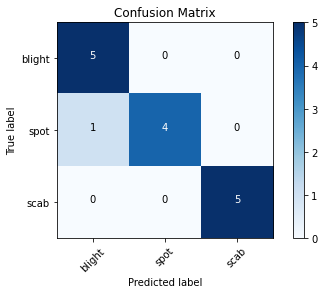

In [15]:
cm_plot_labels = ['blight', 'spot', 'scab']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

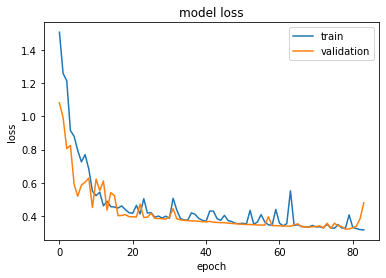

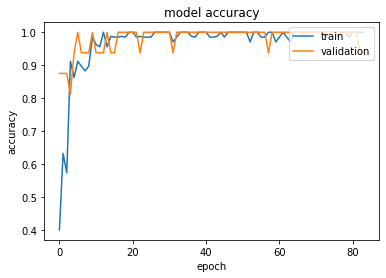

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()